In [13]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

In [39]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

# Model Building

In [40]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [41]:
features = [
       'location', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 'SeedDiff', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT',
       'T2_Rk', 'T2_AdjEM', 'T2_AdjO', 'T2_Strength of Schedule_AdjD',
       'T2_NCSOS_AdjT'
]

features = [
    'T1_win_ratio_14d',
    'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 'SeedDiff', 'T1_Rk',
    'T1_AdjEM', 'T1_AdjO', 'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT',
    'T2_Rk', 'T2_AdjEM', 'T2_AdjO', 'T2_Strength of Schedule_AdjD',
    'T2_NCSOS_AdjT'
]

df = tourney_data.dropna(how='any')

X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

# group_kfold = GroupKFold(n_splits=len(set(groups)))

In [42]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

## Random Forest
Just to get warmed up again.

In [46]:
random_state = 1
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

%time model.fit(X_train, y_train)

print_score(model)

Wall time: 248 ms
train log loss:  0.13725532647832867
val log loss:  0.5348223972651062
training r^2:  0.9011876509156056
validation r^2:  0.29951422497223534


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


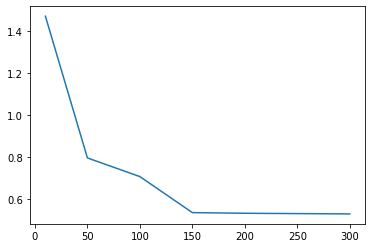

In [63]:
n_trees = [10, 50, 100, 150, 200, 300]
val_log_loss = []
for n in n_trees:
    model = RandomForestRegressor(
        n_estimators=n, n_jobs=-1, oob_score=True, random_state=random_state
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(n_trees, val_log_loss)

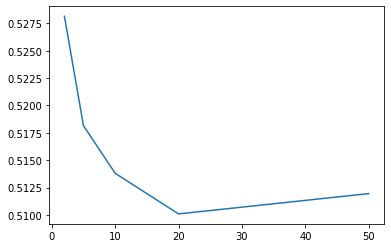

In [67]:
params = dict(
    n_jobs=-1,
    oob_score=True, 
    n_estimators=150,
)

min_samples_leaf = [2, 5, 10, 20, 50]
val_log_loss = []
for msl in min_samples_leaf:
    model = RandomForestRegressor(  
        min_samples_leaf=msl,
        **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(min_samples_leaf, val_log_loss)

In [68]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['min_samples_leaf'] = min_samples_leaf[idx]

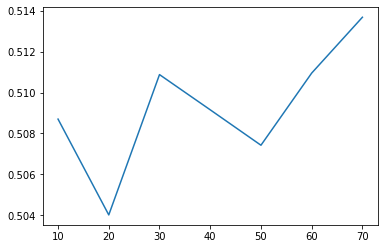

In [69]:
max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70]

val_log_loss = []
for m in max_leaf_nodes:
    model = RandomForestRegressor(
     max_leaf_nodes=m, **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(max_leaf_nodes, val_log_loss)
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))

In [70]:
params['max_leaf_nodes'] = max_leaf_nodes[idx]
print("Max leaf nodes: ", max_leaf_nodes[idx])

Max leaf nodes:  20


In [71]:
print(params)
model = RandomForestRegressor(
     **params
    )
model.fit(X_train, y_train)
print_score(model)

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 150, 'min_samples_leaf': 20, 'max_leaf_nodes': 20}
train log loss:  0.42717101454686945
val log loss:  0.5064004764168678
training r^2:  0.4498398924325429
validation r^2:  0.3263477706522231
oob score:  0.32347332287631547


## CV Pipe

In [81]:
from sklearn.model_selection import LeaveOneGroupOut
def cv_score(m, X_test_, y_test_, print_=True):
    res = log_loss(y_test_, m.predict(X_test_))
    if print_: print(f"Val log loss: {res}")
    return res

def leave_one_out_CV(estimater, params, folds, df, features):
    X = df[features].copy()
    y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
    groups = df['Season'].values - 2003

    # split training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


    cv_res = {}
    group_kfold = LeaveOneGroupOut()
    groups_ = groups[X_train.index]

    for i in range(folds):
        print(f"Fold repeater {i}")
        cv_res[i] = []
        for train_index, test_index in group_kfold.split(X_train.values, y_train, groups_):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train[train_index], y_train[test_index]

            if hasattr(estimator, "random_state"):
                params['random_state'] = i

            m = estimater(**params)
            m.fit(X_train_, y_train_)
            cv_res[i].append(cv_score(m, X_test_, y_test_, print_=False))
        print(f"Fold Log Loss: {np.mean(cv_res[i])}")

    cv_results = [np.mean(vals) for i, vals in cv_res.items()]
    print("CV Fold Results", cv_results)
    print("Mean CV Log Loss: ", np.mean(cv_results))

In [82]:
df = tourney_data.dropna(how='any').reset_index(drop=True)

leave_one_out_CV(estimater=RandomForestRegressor, params=params, 
                 folds=3, df=df, features=features)

Fold repeater 0
Fold Log Loss: 0.48496709323237075
Fold repeater 1
Fold Log Loss: 0.48474398195871454
Fold repeater 2
Fold Log Loss: 0.48450253374367686
CV Fold Results [0.48496709323237075, 0.48474398195871454, 0.48450253374367686]
Mean CV Log Loss:  0.4847378696449207


In [83]:
from sklearn.linear_model import LinearRegression

leave_one_out_CV(estimater=LinearRegression, params={}, folds=3, df=df, features=features)

Fold repeater 0
Fold Log Loss: 0.6462987497953133
Fold repeater 1
Fold Log Loss: 0.6462987497953133
Fold repeater 2
Fold Log Loss: 0.6462987497953133
CV Fold Results [0.6462987497953133, 0.6462987497953133, 0.6462987497953133]
Mean CV Log Loss:  0.6462987497953133
